<a href="https://colab.research.google.com/github/yashlad27/LSTM_basics/blob/main/tuning_hyperparameters_with_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['TSLA.csv']))

Saving TSLA.csv to TSLA (2).csv


In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


In [8]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [10]:
check_df(df)

######################### Head #########################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
######################### Tail #########################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2413  2020-01-30  632.419983  650.880005  618.000000  640.809998  640.809998   
2414  2020-01-31  640.000000  653.000000  632.520020  650.570007  650.570007   
2415  2020-02-03  673.690002  786.14

In [11]:
df["Date"] = pd.to_datetime(df["Date"])
tesla_df = df[["Date", "Close"]]
tesla_df.index = tesla_df["Date"]
tesla_df.drop("Date", axis=1, inplace=True)
tesla_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


In [12]:
result_df = tesla_df.copy()
tesla_df = tesla_df.values
tesla_df = tesla_df.astype("float32")
tesla_df[0:5]

array([[23.89],
       [23.83],
       [21.96],
       [19.2 ],
       [16.11]], dtype=float32)

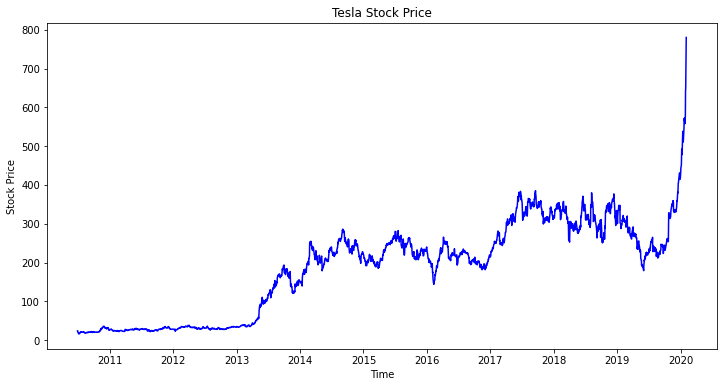

In [13]:
plt.figure(figsize=(12,6))
plt.plot(result_df["Close"], color="blue")
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.title("Tesla Stock Price")
plt.show()

In [14]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [15]:
train, test, position = split_data(tesla_df, 0.20)
print("Train shape:", train.shape, " Test shape:", test.shape)

Train shape: (1933, 1)  Test shape: (483, 1)


In [19]:
def encoding_scaling(train, test):
  scaler_train = MinMaxScaler(feature_range=(0,1))
  train = scaler_train.fit_transform(train)
  scaler_test = MinMaxScaler(feature_range=(0,1))
  test = scaler_test.fit_transform(test)
  return scaler_train, train, scaler_test, test

In [20]:
scaler_train, train, scaler_test, test = encoding_scaling(train, test)

In [21]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X), np.array(Y)

In [22]:
lookback=20
X_train, y_train = create_features(train, lookback)
X_test, y_test = create_features(test, lookback)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (1913, 20)  y_train shape: (1913,) 
X_test shape: (463, 20)  y_test shape:  (463,)


In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (1913, 1, 20)  y_train shape: (1913, 1) 
X_test shape: (463, 1, 20)  y_test shape:  (463, 1)


In [30]:
def LSTM_create_and_fit_model(X_train,y_train, X_test, y_test, lookback=20, epochs=100, summary=True, fit=True):
  model = Sequential()
  model.add(LSTM(units=50, activation="relu", input_shape=(X_train.shape[1], lookback)))
  model.add(Dropout(0.2))
  model.add(Dense(1))

  model.compile(loss="mean_squared_error", optimizer="adam")
  callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"), 
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]
  
  if summary:
    model.summary()
  
  if fit:
    history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=20, 
                      validation_data=(X_test, y_test), callbacks=callbacks, shuffle=False)
  
  return model, history

In [31]:
model, history = LSTM_create_and_fit_model(X_train,y_train, X_test, y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0096
Epoch 1: val_loss improved from inf to 0.00385, saving model to mymodel.h5
96/96 [==============================] - 3s 7ms/step - loss: 0.0097 - val_loss: 0.0039
Epoch 2/100
80/96 [========================>.....] - ETA: 0s - loss: 0.0061


In [32]:
def LSTM_model_evaluate(model):
  loss = model.evaluate(X_test, y_test, batch_size=20)
  print("Test Loss: %.2f" % (100 * loss))
  plt.figure(figsize=(10,5))
  plt.plot(history.history["loss"], color="r", label="Training Loss")
  plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16);

24/24 [==============================] - 0s 2ms/step - loss: 0.0029
Test Loss: 0.29


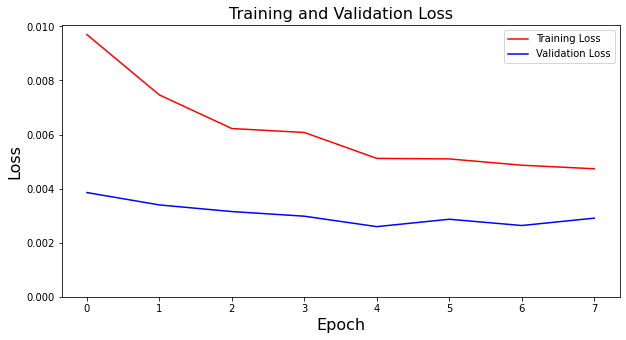

In [33]:
LSTM_model_evaluate(model)

In [34]:
def show_prediction(model, dataframe, X_train, X_test, y_train, y_test, lookback=20, plot=True):
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  train_predict = scaler_train.inverse_transform(train_predict)
  test_predict = scaler_test.inverse_transform(test_predict) 
  y_train = scaler_train.inverse_transform(y_train)
  y_test = scaler_test.inverse_transform(y_test)
  RMSE_train = np.sqrt(mean_squared_error(y_train, train_predict))
  RMSE_test = np.sqrt(mean_squared_error(y_test, test_predict))
  print("############### Loss ###############")
  print("RMSE Train: ", RMSE_train, "\nRMSE Test: ", RMSE_test)

  train_prediction_df = dataframe[lookback:position]
  train_prediction_df["Predicted"] = train_predict
  print("############### Train Predictoion Head ###############")
  print(train_prediction_df.head())

  test_prediction_df = dataframe[position+lookback:]
  test_prediction_df["Predicted"] = test_predict
  print("############### Test Predictoion Head ###############")
  print(test_prediction_df.head())

  if plot:
    plt.figure(figsize=(14,5))
    plt.plot(dataframe, label="Real Number of Passengers")
    plt.plot(train_prediction_df["Predicted"], color="blue", label="Train Predicted Stock Price")
    plt.plot(test_prediction_df["Predicted"], color="red", label="Test Predicted Stock Price")
    plt.title("Tesla Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

15/15 [==============================] - 0s 3ms/step
############### Loss ###############
RMSE Train:  20.371078 
RMSE Test:  32.412537
############### Train Predictoion Head ###############
                Close  Predicted
Date                            
2010-07-28  20.719999  31.770124
2010-07-29  20.350000  31.752583
2010-07-30  19.940001  31.739342
2010-08-02  20.920000  31.735056
2010-08-03  21.950001  31.737738
############### Test Predictoion Head ###############
                 Close   Predicted
Date                              
2018-04-03  267.529999  294.364777
2018-04-04  286.940002  291.490448
2018-04-05  305.720001  288.877045
2018-04-06  299.299988  288.430389
2018-04-09  289.660004  287.613800


<ipython-input-34-c5f201cb9f3b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prediction_df["Predicted"] = train_predict
<ipython-input-34-c5f201cb9f3b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prediction_df["Predicted"] = test_predict


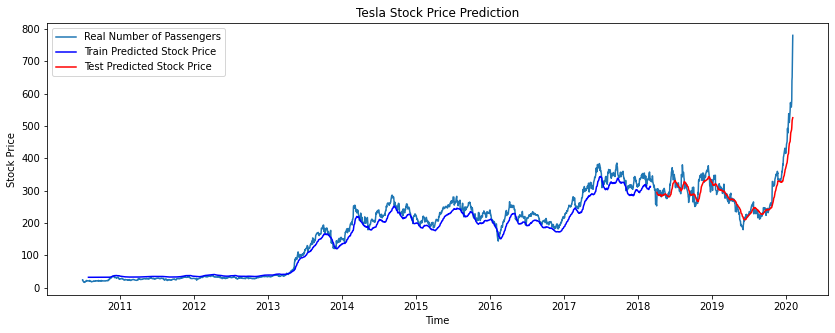

In [35]:
show_prediction(model, result_df, X_train, X_test, y_train, y_test)